# Классификация зловредного ПО

## Описание исследования

**Бизнес-контекст:**    
В современном мире мобильные устройства, особенно с операционной системой Android, стали неотъемлемой частью нашей повседневной жизни. Однако с ростом популярности Android появилась и угроза зловредного программного обеспечения. Более миллиарда человек используют смартфоны, и ожидается, что к 2025 году число пользователей мобильных телефонов достигнет 7,49 миллиарда.   

С появлением Android увеличилась и активность разработчиков зловредного программного обеспечения. Около 2,5 миллионов новых образцов Android-вредоносных программ обнаруживаются ежегодно. Это создает угрозу для безопасности и конфиденциальности пользователей Android.    

Предложенное задание направлено на разработку модели машинного обучения для обнаружения зловредного программного обеспечения на устройствах Android. Задача включает в себя сравнение производительности нескольких классификаторов с использованием нового набора данных и анализ ключевых признаков, влияющих на классификацию.    

**Формальное описание задачи:**  
Разработать сервис классификации зловредного и безвредного программного обеспечения.    

**ML-задачи:**
* провести входной анализ данных (EDA)
* определить метрики для оценки эффективности модели
* сформировать baseline-модель
* предложить улучшенную модель

**Описание датасета:**
Датасет содержит данные о мобильных устройствах на платформе Android и образцах зловредного программного обеспечения. Всего в датасете 4465 экземпляров ПО и 241 предварительно обработанный категориальный признак. Целевым признаком для классификации является значение поля label - отношение ПО к зловредному (1) или доверенному (0).


## Исследовательский анализ данных

### Импорт библиотек и загрузка данных

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import joblib
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, RocCurveDisplay, classification_report, confusion_matrix
from sklearn.utils import shuffle

In [3]:
DATA_PATH = "TUANDROMD.csv"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [4]:
# чтение файлов с данными и сохранение в df
df = pd.read_csv(DATA_PATH)

In [5]:
# получение первых пяти строк таблицы
df.head()

,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
columns = df.columns.tolist()
print(columns)

['ACCESS_ALL_DOWNLOADS', 'ACCESS_CACHE_FILESYSTEM', 'ACCESS_CHECKIN_PROPERTIES', 'ACCESS_COARSE_LOCATION', 'ACCESS_COARSE_UPDATES', 'ACCESS_FINE_LOCATION', 'ACCESS_LOCATION_EXTRA_COMMANDS', 'ACCESS_MOCK_LOCATION', 'ACCESS_MTK_MMHW', 'ACCESS_NETWORK_STATE', 'ACCESS_PROVIDER', 'ACCESS_SERVICE', 'ACCESS_SHARED_DATA', 'ACCESS_SUPERUSER', 'ACCESS_SURFACE_FLINGER', 'ACCESS_WIFI_STATE', 'activityCalled', 'ACTIVITY_RECOGNITION', 'ACCOUNT_MANAGER', 'ADD_VOICEMAIL', 'ANT', 'ANT_ADMIN', 'AUTHENTICATE_ACCOUNTS', 'AUTORUN_MANAGER_LICENSE_MANAGER', 'AUTORUN_MANAGER_LICENSE_SERVICE(.autorun)', 'BATTERY_STATS', 'BILLING', 'BIND_ACCESSIBILITY_SERVICE', 'BIND_APPWIDGET', 'BIND_CARRIER_MESSAGING_SERVICE', 'BIND_DEVICE_ADMIN', 'BIND_DREAM_SERVICE', 'BIND_GET_INSTALL_REFERRER_SERVICE', 'BIND_INPUT_METHOD', 'BIND_NFC_SERVICE', 'BIND_0TIFICATION_LISTENER_SERVICE', 'BIND_PRINT_SERVICE', 'BIND_REMOTEVIEWS', 'BIND_TEXT_SERVICE', 'BIND_TV_INPUT', 'BIND_VOICE_INTERACTION', 'BIND_VPN_SERVICE', 'BIND_WALLPAPER', 'B

### EDA и предобработка

In [7]:
# получение общей информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4465 entries, 0 to 4464
Columns: 242 entries, ACCESS_ALL_DOWNLOADS to Label
dtypes: float64(242)
memory usage: 8.2 MB


In [8]:
# подсчет пропущенных значений
df.isna().sum()

ACCESS_ALL_DOWNLOADS                                        1
ACCESS_CACHE_FILESYSTEM                                     1
ACCESS_CHECKIN_PROPERTIES                                   1
ACCESS_COARSE_LOCATION                                      1
ACCESS_COARSE_UPDATES                                       1
                                                           ..
Landroid/telephony/TelephonyManager;->getSimOperatorName    1
Landroid/telephony/TelephonyManager;->getSimCountryIso      1
Landroid/telephony/TelephonyManager;->getSimSerialNumber    1
Lorg/apache/http/impl/client/DefaultHttpClient;->execute    1
Label                                                       1
Length: 242, dtype: int64

In [9]:
# удаление пропусков
df = df.dropna()

In [10]:
# числовое описание данных
round(df.describe(), 0)

,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute,Label
count,4464.0,4464.0,4464.0,4464.0,4464.0,4464.0,4464.0,4464.0,4464.0,4464.0,...,4464.0,4464.0,4464.0,4464.0,4464.0,4464.0,4464.0,4464.0,4464.0,4464.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [11]:
# оценка баланса классов
df["Label"].value_counts(normalize=True)

1.0    0.798611
0.0    0.201389
Name: Label, dtype: float64

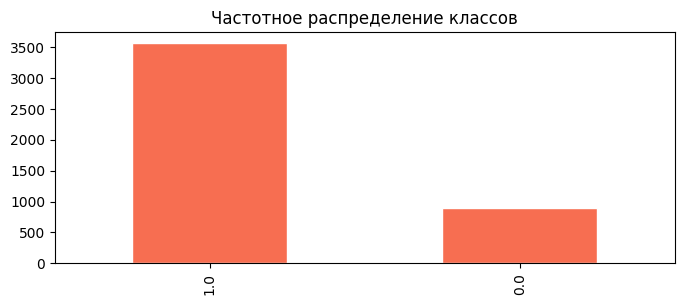

In [12]:
df["Label"].value_counts().plot(kind='bar', figsize=(8, 3), ec='white',
                              color='#F76E51', title="Частотное распределение классов");

#### Борьба с дисбалансом классов

In [13]:
y = df['Label']
X = df.drop(['Label'], axis = 1)
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X, y)

print('Размер исходного датасета', y.shape)
print('Размер сбалансированного датасета', y_smote.shape)

Размер исходного датасета (4464,)
Размер сбалансированного датасета (7130,)


In [14]:
# оценка баланса классов
y_smote.value_counts(normalize=True)

1.0    0.5
0.0    0.5
Name: Label, dtype: float64

### Подготовка выборок

Разделим данные на обучающую (80%) и тестовую (20%) выборки:

In [15]:
# разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.2, random_state=SEED)

## Определение метрик для оценки эффективности модели

В задачах бинарной классификации применяется ряд метрик, которые оценивают качество модели с различных точек зрения.    
Для оценки качества модели будет применяться **F1-мера**, которая является гармоническим средним между точностью и полнотой и обеспечивает баланс между ними: $F1=2×\frac{Precision × Recall}{Precision + Recall}$    
В качестве вспомогательной метрики будет рассчитан **ROC-AUC**, а также отображена **ROC-кривая**, для наглядной оценки баланса между чувствительностью и специфичностью.     
Кроме качества моделей на конечных задачах, будем замерять их производительность (среднее число миллисекунд на предикт одного объкта при запуске на CPU либо GPU) и размер (в мегабайтах, которые модель занимает на диске).

## Baseline-модель

В качестве baseline-модели будем использовать случайную модель, которая просто предсказывает класс случайным образом.

In [16]:
def random_model(X):
    # Генерация случайных предсказаний
    predictions = np.random.choice([0, 1], size=len(X))
    # Генерация случайных вероятностей между 0 и 1
    probabilities = np.random.rand(len(X))
    return predictions, probabilities

In [17]:
predictions_RM, probabilities_RM  = random_model(X_test)

In [18]:
f1_RM = round(f1_score(y_test, predictions_RM), 3)
print("F1 случайной модели:", f1_RM)

F1 случайной модели: 0.501


ROC-AUC случайной модели: 0.497


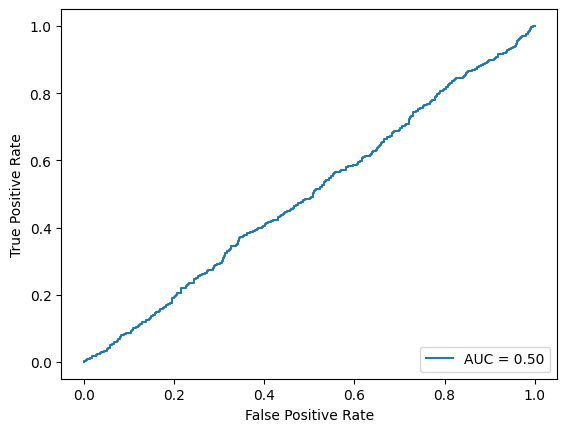

In [19]:
fpr, tpr, _ = roc_curve(y_test, probabilities_RM)

roc_auc_RM = round(roc_auc_score(y_test, probabilities_RM), 3)
print("ROC-AUC случайной модели:", roc_auc_RM)

# Построение ROC-кривой
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_RM)
roc_display.plot()
plt.show()

## Обучение моделей

Обучим несколько моделей из различных семейств:    

1) **LogisticRegression:** это линейный метод классификации, использующий логистическую функцию для моделирования вероятности принадлежности экземпляра к определенному классу.

2) **RandomForestClassifier:** это ансамбль деревьев решений, где каждое дерево обучается на случайном подмножестве данных и признаков. Относится к семейству ансамблевых моделей.

3) **CatBoostClassifier:** это градиентный бустинговый алгоритм, разработанный для работы с категориальными признаками. Относится к семейству градиентного бустинга.

4) **AdaBoostClassifier:** это еще один градиентный бустинговый алгоритм, который комбинирует несколько слабых (недообученных) моделей для создания сильной модели.

5) **GaussianProcessClassifier:** классификатор на основе гауссовских процессов. Он использует гауссовский процесс для моделирования распределения вероятностей по классам.

6) **MLPClassifier:** многослойный перцептрон - это нейронная сеть, состоящая из нескольких слоев нейронов.

### Определение параметров и функций

In [20]:
CV = 3 #количество итераций при кросс-валидации

params_LR = {'solver': ['liblinear', 'saga'],  # Алгоритм оптимизации
                 'penalty': ['l1', 'l2'],  # Штраф за норму
                 'class_weight': [None, 'balanced'],  # Веса классов
                 'C': [0.001, 0.01, 0.1, 1, 10, 100]    # Обратная сила регуляризации
             }

params_RF = {'n_estimators': [10, 30, 50],  # Количество деревьев
                 'max_depth': [10, 20, 30, 40, 50]  # Максимальная глубина каждого дерева
             }

params_CB = {'depth': [4, 6, 8, 10]
             }  # Максимальная глубина деревьев (the optimal depth ranges from 4 to 10)

params_AB = {'learning_rate': [0.01, 0.1, 0.5, 1.0]  # Learning rate
                 }

params_GP = {'max_iter_predict': [100, 200, 300]
             }    # Максимальное количество итераций при предсказании


params_MLP = {'alpha': [0.0001, 0.001, 0.01, 0.5, 1]
              }    # Параметр регуляризации


models_list = [[LogisticRegression(random_state=SEED), params_LR, "Logistic regression"],
               [RandomForestClassifier(random_state=SEED), params_RF, "Random Forest"],
               [CatBoostClassifier(random_state=SEED, verbose=False, task_type="GPU", devices='0:1'), params_CB, "CatBoost"],
               [AdaBoostClassifier(random_state=SEED), params_AB, "Adaboost"],
               [GaussianProcessClassifier(random_state=SEED), params_GP, "Gaussian Process"],
               [MLPClassifier(max_iter=1000, random_state=SEED), params_MLP, "MLP Classifier"]
               ]

In [21]:
def grid_search_cv(model, features_train, target_train, features_test, target_test, parameters):

    # cross-validation and hyperparameter selection
    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=CV, scoring='f1',
                        n_jobs=-1, error_score='raise')

    grid.fit(features_train, target_train)
    best_params = grid.best_params_
    print("Наилучшие параметры:", best_params)

    # prediction based on the best parameters
    best_model = model.set_params(**best_params)
    best_model.fit(features_train, target_train)
    predictions = best_model.predict(features_test)
    probabilities = best_model.predict_proba(features_test)[:, 1]
    fpr, tpr, _ = roc_curve(target_test, probabilities)

    # metrics
    f1 = round(f1_score(target_test, predictions), 3)
    roc_auc = round(roc_auc_score(target_test, probabilities), 3)

    print(f'f1:', f1)
    print(f'ROC-AUC:', roc_auc)
    print()

    # Построение ROC-кривой
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display.plot()
    plt.show()
    print("\n")

    # Построение матрицы ошибок
    cnf = confusion_matrix(target_test, predictions)
    fig, ax = plot_confusion_matrix(conf_mat = cnf)
    plt.show()
    print("\n")

    # Classification report
    classes = {0: 'Goodware', 1: 'Malware'}
    clf_report = classification_report(predictions, target_test, target_names = list(classes.values()))
    print(clf_report)

    return f1, roc_auc, best_model

### Обучение и тестирование различных моделей

Модель: Logistic regression
Наилучшие параметры: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
f1: 0.988
ROC-AUC: 0.999



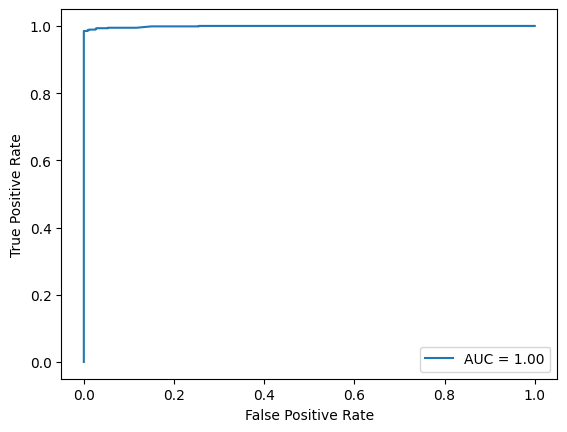

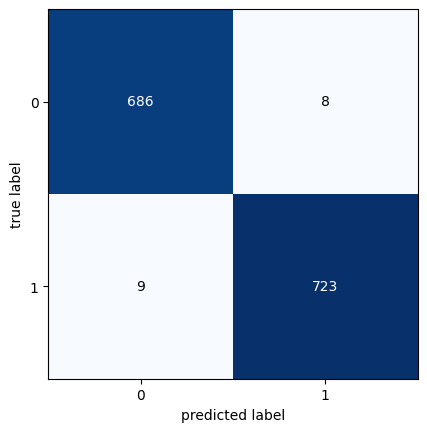



              precision    recall  f1-score   support

    Goodware       0.99      0.99      0.99       695
     Malware       0.99      0.99      0.99       731

    accuracy                           0.99      1426
   macro avg       0.99      0.99      0.99      1426
weighted avg       0.99      0.99      0.99      1426

Модель: Random Forest
Наилучшие параметры: {'max_depth': 30, 'n_estimators': 50}
f1: 0.997
ROC-AUC: 1.0



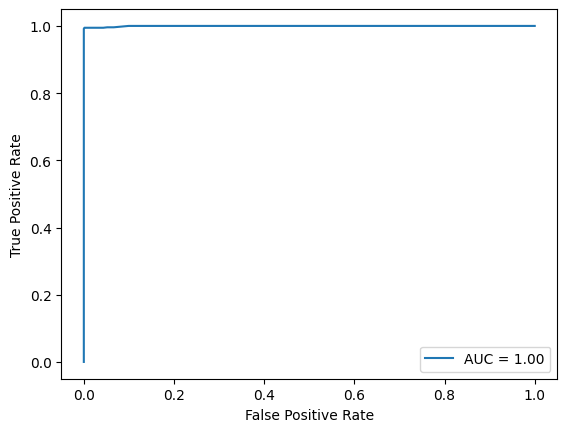

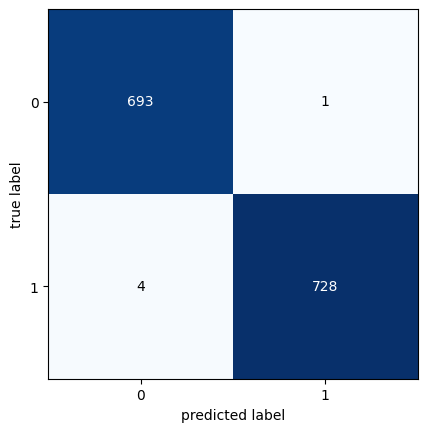



              precision    recall  f1-score   support

    Goodware       1.00      0.99      1.00       697
     Malware       0.99      1.00      1.00       729

    accuracy                           1.00      1426
   macro avg       1.00      1.00      1.00      1426
weighted avg       1.00      1.00      1.00      1426

Модель: CatBoost


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Наилучшие параметры: {'depth': 8}
f1: 0.995
ROC-AUC: 1.0



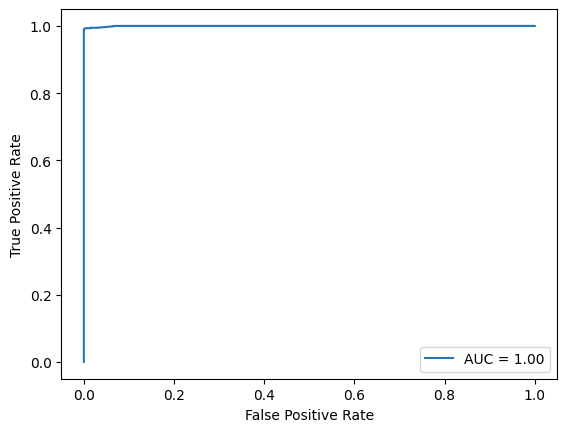

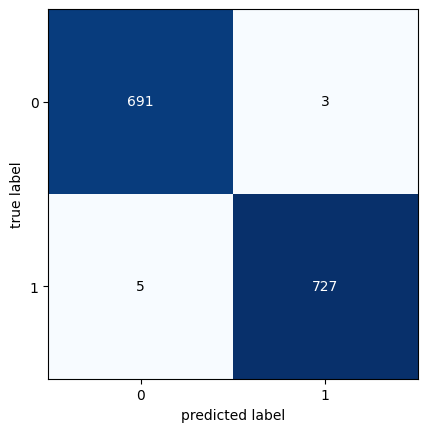



              precision    recall  f1-score   support

    Goodware       1.00      0.99      0.99       696
     Malware       0.99      1.00      0.99       730

    accuracy                           0.99      1426
   macro avg       0.99      0.99      0.99      1426
weighted avg       0.99      0.99      0.99      1426

Модель: Adaboost
Наилучшие параметры: {'learning_rate': 0.5}
f1: 0.985
ROC-AUC: 0.998



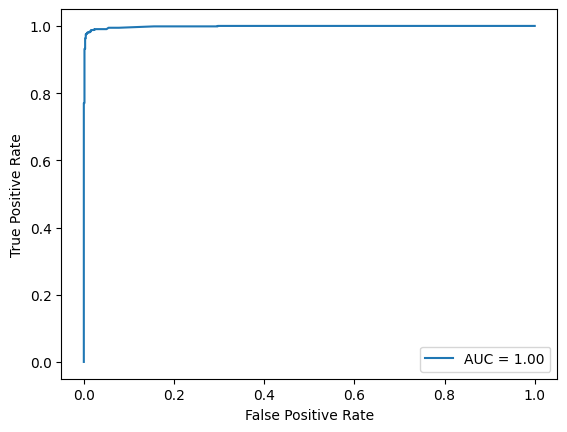

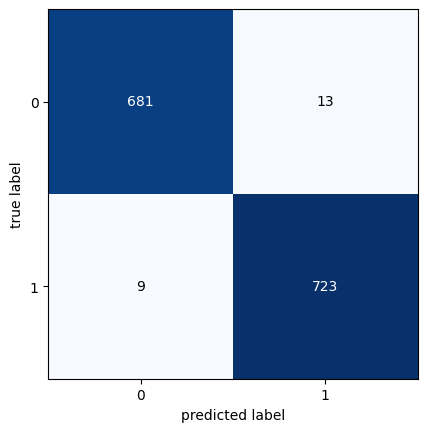



              precision    recall  f1-score   support

    Goodware       0.98      0.99      0.98       690
     Malware       0.99      0.98      0.99       736

    accuracy                           0.98      1426
   macro avg       0.98      0.98      0.98      1426
weighted avg       0.98      0.98      0.98      1426

Модель: Gaussian Process
Наилучшие параметры: {'max_iter_predict': 100}
f1: 0.995
ROC-AUC: 0.996



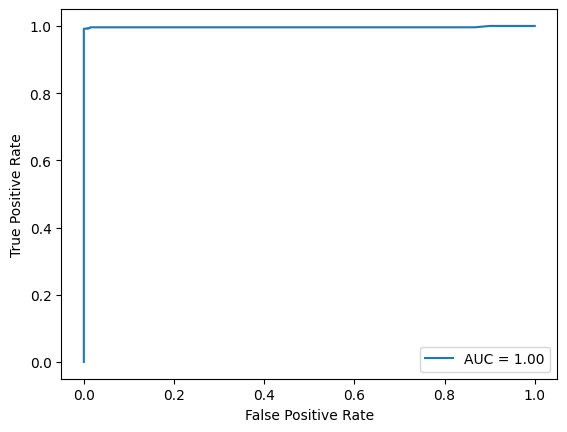

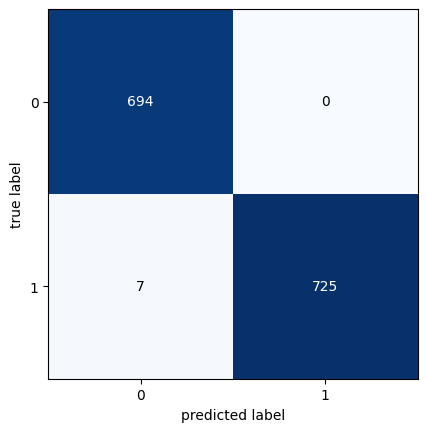



              precision    recall  f1-score   support

    Goodware       1.00      0.99      0.99       701
     Malware       0.99      1.00      1.00       725

    accuracy                           1.00      1426
   macro avg       1.00      1.00      1.00      1426
weighted avg       1.00      1.00      1.00      1426

Модель: MLP Classifier
Наилучшие параметры: {'alpha': 0.0001}
f1: 0.995
ROC-AUC: 0.999



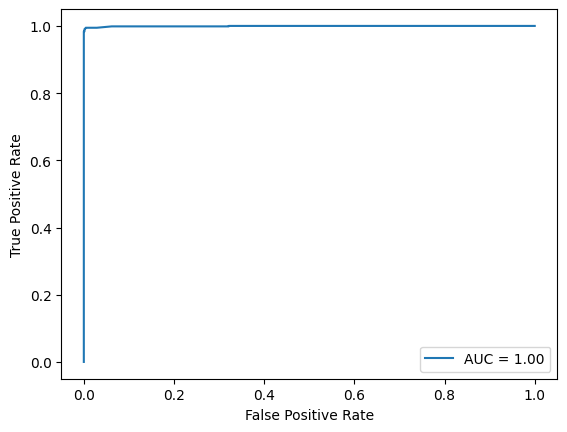

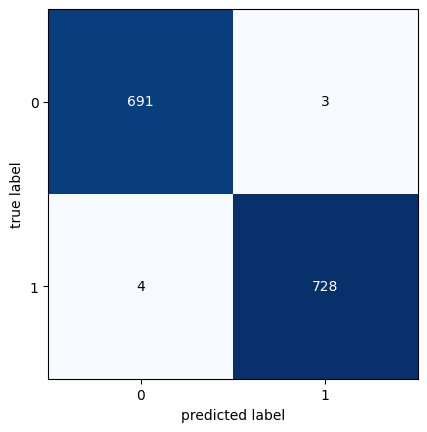



              precision    recall  f1-score   support

    Goodware       1.00      0.99      0.99       695
     Malware       0.99      1.00      1.00       731

    accuracy                           1.00      1426
   macro avg       1.00      1.00      1.00      1426
weighted avg       1.00      1.00      1.00      1426



In [22]:
results_metrics = {}  # Создание пустого словаря для хранения результатов

for model in models_list:
  print("Модель:", model[2])
  f1, roc_auc, trained_model = grid_search_cv(model[0], X_train, y_train, X_test, y_test, model[1])

  # Сохранение модели в формате joblib
  model_name = model[2].replace(" ", "_").lower()  # Преобразование имени модели в нижний регистр и замена пробелов
  joblib.dump(trained_model, f'{model_name}_model.joblib')

  # Сохранение результатов в словаре
  results_metrics[model[2]] = {'f1': f1, 'roc_auc': roc_auc}

### Измерение производительности

In [62]:
import time
import os

def measure_performance(model, features_test):
    start_time = time.time()
    predictions = model.predict(features_test[:1])  # Измеряем только на одном объекте
    end_time = time.time()
    average_prediction_time = round((end_time - start_time) * 1000, 1)  # в миллисекундах
    print(f"Среднее время предсказания на одном объекте: {average_prediction_time:.1f} мс")
    return average_prediction_time

def measure_model_size(model, model_name):
    model_size_mb = round(os.path.getsize(f'{model_name}_model.joblib') / (1024 * 1024), 2)  # в мегабайтах
    print(f"Размер модели на диске: {model_size_mb:.2f} МБ")
    return model_size_mb

In [63]:
results_perfomance = {}  # Создание пустого словаря для хранения результатов

for model in models_list:
    print("Модель:", model[2])
    model_name = model[2].replace(" ", "_").lower()
    pretrained_model = joblib.load(f'{model_name}_model.joblib')

    # Измерение производительности
    performance_time = measure_performance(pretrained_model, X_test)

    # Измерение размера модели
    model_size = measure_model_size(pretrained_model, model_name)
    print("\n")

    # Сохранение результатов в словаре
    results_perfomance[model[2]] = {'performance_time': performance_time, 'model_size': model_size}

Модель: Logistic regression
Среднее время предсказания на одном объекте: 4.5 мс
Размер модели на диске: 0.01 МБ


Модель: Random Forest
Среднее время предсказания на одном объекте: 5.1 мс
Размер модели на диске: 0.89 МБ


Модель: CatBoost
Среднее время предсказания на одном объекте: 14.1 мс
Размер модели на диске: 3.93 МБ


Модель: Adaboost
Среднее время предсказания на одном объекте: 12.9 мс
Размер модели на диске: 0.04 МБ


Модель: Gaussian Process
Среднее время предсказания на одном объекте: 10.3 мс
Размер модели на диске: 258.90 МБ


Модель: MLP Classifier
Среднее время предсказания на одном объекте: 2.8 мс
Размер модели на диске: 0.57 МБ




## Результаты обучения моделей и выводы

В исследовании был проведен EDA с предобработкой данных, входе которого были удалены пропуски, а выборки сбалансированы.    

В качестве основных метрик оценки качества моделей машинного обучения были выбраны F1-мера и ROC-AUC. Кроме того была замерена производительность моделей и их размер.

При тестировании на отложенной выборке лучшие показатели по метрикам показала модель Random Forest. С точки зрения времени инференса и "легковесности" модели самыми быстрыми и легкими оказались модель логистической регрессии и MLP Classifier (Многослойный перцептронный классификатор).        

Таким образом, все представленные ML-модели справились со своей задачей и могут быть использованы для обнаружения зловредного программного обеспечения на устройствах Android.    
Однако, по полученным метрикам качества и производительности для использования в конечном сервисе выбраны модели:    
1) Random Forest: как самая точная модель;    
2) MLP Classifier: как самая сбалансированная по точности и скорости работы модель;    
3) Logistic regression: как менеее точная, но достаточно быстрая и "дешевая" для конечного пользователя.

In [64]:
df_results = pd.DataFrame.from_dict(results_metrics, orient='index')
df_perfomance = pd.DataFrame.from_dict(results_perfomance, orient='index')
df_baseline = pd.DataFrame.from_dict({'Baseline': {'f1': f1_RM, 'roc_auc': roc_auc_RM, 'performance_time': "-" , 'model_size': "-"}}, orient='index')

# Объединение трех DataFrame
final_df = pd.concat([df_results, df_perfomance], axis=1)
final_df = pd.concat([final_df, df_baseline], axis=0)
final_df.sort_values(by=["f1", "roc_auc"], ascending=False, inplace=True)

# Вывод результирующего DataFrame
print(final_df)

                        f1  roc_auc performance_time model_size
Random Forest        0.997    1.000              5.1       0.89
CatBoost             0.995    1.000             14.1       3.93
MLP Classifier       0.995    0.999              2.8       0.57
Gaussian Process     0.995    0.996             10.3      258.9
Logistic regression  0.988    0.999              4.5       0.01
Adaboost             0.985    0.998             12.9       0.04
Baseline             0.501    0.497                -          -
